In [1]:
# 파일이름 : LAB_data_generator.ipynb
# 코드설명 : 고무 배합비와 연구소 검사 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : 배합정보, LAB 검사결과, 원재료코드분류 / LAB 데이터 세트(7개)"
# 최종수정 : 2023년 11월 23일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
#print(font_list)

# 한글 폰트 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 설정 (깨지는 문제 방지)

sns.set(font="NanumGothic", # 일반적으로 설치되어 있는 폰트로 변경
        rc={"axes.unicode_minus": False, "figure.figsize": (20, 8)}, # figure size와 unicode_min
        style='darkgrid',
        font_scale=0.8) # 폰트 크기 설정 추가

import pandas as pd
import numpy as np
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
from tqdm.auto import tqdm

import os
import koreanize_matplotlib
import pingouin as pg

### 1) 데이터 로드

In [2]:
lab_recipe_df=pd.read_csv('./dataset/sfitapp_recipe_lab.csv', encoding='cp949')           # 배합비 데이터
lab_insp_df=pd.read_csv('./dataset/sfitapp_insp_lab.csv', encoding='cp949')         # 검사 데이터
total_df=pd.read_pickle('./dataset/clean_lab_mes_dataset.pkl')

lab_check_info = pd.read_csv('./dataset/LAB_PHR_abnormal_check.csv')
lar_cd_df=pd.read_excel('./dataset/jrcode_230907_fin.xlsx')             # 원재료 코드 및 분류표

In [3]:
lab_df=total_df[total_df['type']=='lab']
lab_df.loc[lab_df['MNY_TEMP'].isna(), 'MNY_TEMP'] = 125
lab_df.loc[lab_df['MNY_TIME'].isna(), 'MNY_TIME'] = 5

In [4]:
# ID 생성
lab_check_info['lab_cd'] = lab_check_info['lab_cd'].str.replace('-','')
lab_check_info['ID'] = lab_check_info['lab_cd'] + '_' + lab_check_info['test_no']

lab_recipe_df['lab_cd'] = lab_recipe_df['lab_cd'].str.replace('-','')
lab_recipe_df['ID'] = lab_recipe_df['lab_cd'] + '_' + lab_recipe_df['test_no']

In [5]:
# remove 목록 제거
remove_ID_ls = list(lab_check_info[lab_check_info['type']=='remove']['ID'])
lab_recipe_df = lab_recipe_df[~lab_recipe_df['ID'].isin(remove_ID_ls)]

# 값 변경
lab_recipe_df['phr'] = np.where((((lab_recipe_df['ID']=='1654IA001_T007') & (lab_recipe_df['com_lar_cd']=='CA005')) |
                         ((lab_recipe_df['ID']=='2697ID001_T015') & (lab_recipe_df['com_lar_cd']=='CA008'))), lab_recipe_df['phr']/10, lab_recipe_df['phr'])
lab_check_info[lab_check_info['type']=='divideby10']

,com_lar_cd,lar_cd,lab_cd,test_no,phr,type,ID
2,CA005,CA005B,1654IA001,T007,6.0,divideby10,1654IA001_T007
4,CA008,CA008D,2697ID001,T015,12.0,divideby10,2697ID001_T015


In [6]:
lab_recipe_df.merge(lab_check_info[lab_check_info['type']=='divideby10'][['ID','com_lar_cd']], how='inner', on=['ID','com_lar_cd'])

,lab_cd,test_no,srt_sqn,asgm_yn,com_lar_cd,com_lar_nm,lar_cd,lar_nm,hs_vl,sg_vl,phr,inpt_wgt,mix_ds_cd,fct_cd,vol_vl,phr_sum,inpt_wgt_sum,hs_vl_sum,sg_vl_sum,ID
0,1654IA001,T007,13,N,CA005,M(MBT)ⓒ,CA005B,M(MBT)_Sunsine,0.0,1.148,0.6,9.32,-F1,T-4-01,80.00,285.5,443.23,68.75,1.108,1654IA001_T007
1,2697ID001,T015,16,N,CA008,CZ(CBS)ⓒ,CA008D,CZ(CBS)_Ruida,0.0,1.270,1.2,26.40,-F1,B-5-01,0.35,256.7,565.24,81.98,1.291,2697ID001_T015


### 2) 배합비와 검사 데이터, 원자재코드표 결합

In [7]:
# 기본 정보
recipe_cols=['ID','mix_ds_cd','srt_sqn','lar_cd','phr']

# 기본물성 관련 검사 조건
base_pps_cols = ['HS','SG','TS','EB']
insp_pps_cols=[col for col in lab_df.columns if (len([inCol for inCol in base_pps_cols if inCol in col]) != 0) and col!='REHO_TS2']

# ,'insp_pps_temp1_val','insp_pps_mnt1_val',
#            'insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

# 가류/점도 관련 검사 조건
spec_pps_cols = ['MNY','REHO']
insp_curing_cols = [col for col in lab_df.columns if (len([inCol for inCol in spec_pps_cols if inCol in col]) != 0)]
# ['insp_rheo_ts2_val','insp_rheo_t90_val','insp_rheo_min_val','insp_rheo_max_val','insp_mny_min_val',
#                     'insp_mny_temp_val','insp_mny_148_val','insp_rheo_temp_val','insp_rheo_mnt_val','insp_mny_t35_val','insp_mny_t5_val']

# 최종 원자재별 결합 데이터 포멧
fin_cols = recipe_cols+insp_pps_cols+insp_curing_cols
# ['ID','mix_ds_cd','srt_sqn','lar_cd','중분류','소분류','phr','insp_pps_temp1_val','insp_pps_mnt1_val',
#           'insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val',
#           'insp_rheo_ts2_val','insp_rheo_t90_val','insp_rheo_min_val','insp_rheo_max_val','insp_mny_min_val',
#           'insp_mny_temp_val','insp_mny_148_val','insp_rheo_temp_val','insp_rheo_mnt_val','insp_mny_t35_val','insp_mny_t5_val']

In [8]:
# 각 열의 null 값의 개수를 계산
null_counts = lab_df.isnull().sum()

# 각 열의 전체 행 수로 나누고 100을 곱하여 퍼센트로 변환
null_percentages = np.round((null_counts / len(lab_df)) * 100, 2)
null_percentages

EB           37.78
EB_TEMP       8.63
EB_TIME       8.70
HS           37.17
HS_TEMP       8.63
HS_TIME       8.70
ID            0.00
MNY_MIN      56.53
MNY_T35      55.01
MNY_T5       46.69
MNY_TEMP      0.00
MNY_TIME      0.00
REHO_MAX     37.98
REHO_MIN     45.07
REHO_TC90    46.49
REHO_TEMP     6.84
REHO_TIME     7.13
REHO_TS2     40.74
SG           39.22
SG_TEMP       8.63
SG_TIME       8.70
TS           39.80
TS_TEMP       8.63
TS_TIME       8.70
type          0.00
dtype: float64

In [9]:
# lab_pk 생성 및 데이터 결합
display(f"검사 데이터의 lab_pk 수: {lab_df['ID'].nunique():,}, 레시피 데이터의 lab_pk 수: {lab_recipe_df['ID'].nunique():,}")
display(f"교차: {len(set(lab_df['ID'].unique().tolist()).intersection(set(lab_recipe_df['ID'].unique().tolist()))):,}")

# 레시피와 검사 데이터 결합
fin_lab_df=pd.merge(lab_recipe_df[recipe_cols], lab_df[['ID'] + insp_pps_cols + insp_curing_cols], how='inner', on='ID')
# lar_cd가 Nan인 행 제거
print(fin_lab_df.columns)
fin_lab_df[~fin_lab_df['lar_cd'].isna()].reset_index(drop=True, inplace=True)
len(fin_lab_df)

'검사 데이터의 lab_pk 수: 7,438, 레시피 데이터의 lab_pk 수: 7,387'

'교차: 7,362'

Index(['ID', 'mix_ds_cd', 'srt_sqn', 'lar_cd', 'phr', 'EB', 'EB_TEMP',
       'EB_TIME', 'HS', 'HS_TEMP', 'HS_TIME', 'SG', 'SG_TEMP', 'SG_TIME', 'TS',
       'TS_TEMP', 'TS_TIME', 'MNY_MIN', 'MNY_T35', 'MNY_T5', 'MNY_TEMP',
       'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP',
       'REHO_TIME', 'REHO_TS2'],
      dtype='object')


114023

## 2. 최종 LAB 데이터 세트 저장
- 물성값 : 기본물성(4개), 가류/점도(7개)

In [10]:
# 임시 데이터 저장
fin_lab_df.to_csv('./tmp_dataset/total_lab_data.csv', index=False, encoding='cp949')

### 예측 대상별 최종 LAB 데이터 세트 생성 및 저장

In [11]:
x_cols=['ID','mix_ds_cd','lar_cd','srt_sqn','phr']
# 기본물성
pps_y_cols=['HS','SG','TS','EB']
# 가류도
curing_y_cols = ['MNY_MIN','MNY_T35','MNY_T5','REHO_MAX','REHO_MIN','REHO_TC90','REHO_TS2']

yCols = pps_y_cols + curing_y_cols

for yCol in yCols:
    if yCol in pps_y_cols:
        insp_condi_cols = [yCol+'_TEMP',yCol+'_TIME']
    else:
        if 'MNY' in yCol:
            insp_condi_cols= ['MNY_TEMP','MNY_TIME']
        else:
            insp_condi_cols= ['REHO_TEMP','REHO_TIME']
    
    tmp_fin_df=fin_lab_df[x_cols+insp_condi_cols+[yCol]].dropna()
    if len(tmp_fin_df.columns) > 8:
        tmp_fin_df = tmp_fin_df.iloc[:,:-1]
    tmp_fin_df.columns = ['ID','mix_ds_cd','JRCODE','srt_sqn','PHR','INSP_TEMP','INSP_TIME',yCol]
    if len(tmp_fin_df) == 0:
        continue
    
    # group_df = fin_lab_df.groupby(['ID'])['srt_sqn'].max().reset_index()
    # lower_limit = group_df['srt_sqn'].mean() - group_df['srt_sqn'].std()*2
    # upper_limit = group_df['srt_sqn'].mean() + group_df['srt_sqn'].std()*2
    # tmp_df = group_df[(group_df['srt_sqn'].between(lower_limit, upper_limit))]

    # fin_df = pd.merge(tmp_fin_df, tmp_df[['ID']], how='inner', on=['ID'])
    tmp_fin_df.to_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv', index=False)

### 고무배합별 최종 LAB 데이터 세트 생성 및 저장

In [12]:
yCols = ['HS', 'SG', 'TS', 'EB', 'MNY_MIN', 'MNY_T35', 'MNY_T5', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TS2']

for yCol in yCols:
    print(yCol)

    # 데이터 로드
    df = pd.read_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv')
    # df['JRCODE'] = df['lar_cd']
    # df['PHR'] = df['phr']

    # 반복 대상 컬럼명
    columns_to_reshape = ['JRCODE','PHR']

    reshaped_rows = []

    # 단일값이어야 하는 것들은 그대로 그룹화
    grouped = df.groupby(['ID', 'INSP_TEMP', 'INSP_TIME', yCol])

    for (ID, INSP_TEMP, INSP_TIME, yCol_val), group in grouped:
        reshaped_row = {'ID': ID, 'INSP_TEMP': INSP_TEMP,
                        'INSP_TIME': INSP_TIME, yCol: yCol_val}  # 새로운 행 초기화
        
        phr_sum = 0
        
        # 'srt_sqn'의 값에 따라 컬럼 이름을 변경하고 값을 저장합니다.
        for col in columns_to_reshape:
            srt_sqn_val = 1
            for _, row in group.iterrows():
                if row['JRCODE'] != '-C1':
                    new_col_name = f"{srt_sqn_val}_{col}"  # 새로운 컬럼 이름 생성
                    reshaped_row[new_col_name] = row[col]  # 값 저장
                    srt_sqn_val += 1

                    if col == 'PHR':
                        phr_sum += row[col]
        
        if phr_sum != 0:
            reshaped_rows.append(reshaped_row)

    # 결과를 데이터프레임으로 변환
    reshaped_df_efficient = pd.DataFrame(reshaped_rows)
    # reshaped_df_efficient.fillna(0, inplace=True)
    reshaped_df_efficient = reshaped_df_efficient[reshaped_df_efficient[yCol]!=0]

    reshaped_df_efficient.to_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv', index = False, encoding="utf-8-sig")

# 결과 확인
reshaped_df_efficient.head(10)

HS
SG
TS
EB
MNY_MIN
MNY_T35
MNY_T5
REHO_MAX
REHO_MIN
REHO_TC90
REHO_TS2


,ID,INSP_TEMP,INSP_TIME,REHO_TS2,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,22_JRCODE,22_PHR,23_JRCODE,23_PHR,24_JRCODE,25_JRCODE,26_JRCODE,24_PHR,25_PHR,26_PHR,27_JRCODE,27_PHR
0,0000QY001_T010,180.0,5.0,69.0,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,CV001D,CA005B,CA013A,CA011D,CA019C,CA003C,CA007C,20.0,58.00,87.00,5.00,1.0,1.00,1.0,1.5,1.5,1.5,210.0,114.0,80.0,40.0,0.8,0.5,0.6,0.7,0.7,1.4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0504PA001_T002,180.0,5.0,106.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,CA019C,CA013A,CC022A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,10.00,1.00,2.00,10.0,15.00,15.0,1.5,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0600QA001_T001,180.0,5.0,52.0,EI001D,CB003A,CB001C,NN774A,CV001D,CA008D,CA011D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,5.00,1.00,60.00,1.5,0.50,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0600QA001_T002,180.0,5.0,43.0,EI001D,CB003A,CB001C,NN774A,CV001D,CA008D,CA011D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,5.00,1.00,60.00,1.5,0.50,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0602PA001_T001,180.0,5.0,91.0,PC001A,CV005B,CC012B,CD008B,OD003D,CG001C,NN774A,CV011A,CV030B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,13.33,0.67,2.67,30.0,3.33,45.0,5.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0602PA001_T002,180.0,5.0,81.0,PC001A,CV005B,CC012B,CD008B,OD003D,CG001C,NN774A,CV011A,CV030B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,15.00,0.67,2.67,30.0,4.00,35.0,6.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0605PA001_T002,180.0,5.0,53.0,EH002A,NA003A,CB001C,CV011A,CV013A,CB003A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,50.00,1.00,3.00,6.0,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0605PA001_T003,180.0,5.0,46.0,EH002A,NA003A,CB001C,CV011A,CV013A,CB003A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,50.00,1.00,3.00,6.0,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0605PA001_T004,180.0,5.0,43.0,EH003A,NA003A,CB001C,CV011A,CV013A,CB003A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,50.00,1.00,3.00,6.0,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0703IA001_T002,180.0,5.0,62.0,EZ044A,CV005B,CB011B,CZ047A,CC022A,NN774A,OD006B,CA011D,CA008D,CA016A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,3.00,0.50,2.00,2.0,40.00,4.0,0.3,0.7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 물성별 Nan과 0값이 아닌 데이터의 수 체크

In [13]:
trg_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
for yCol in trg_cols:
    print(yCol, len(fin_lab_df[~(fin_lab_df[yCol].isna())&(fin_lab_df[yCol]!=0)]))

HS 71662
SG 69401
TS 68791
EB 71004
MNY_MIN 49355
MNY_T5 61005
MNY_T35 51699
REHO_MIN 62717
REHO_MAX 71247
REHO_TS2 67661
REHO_TC90 62265


### 물성별 분포 시각화

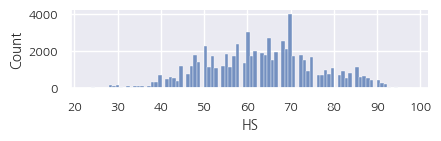

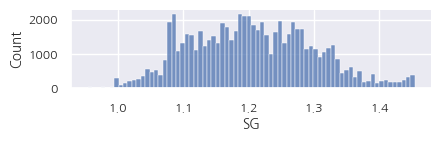

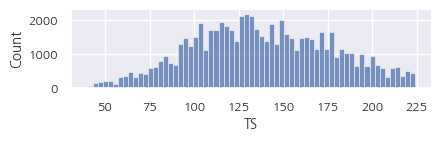

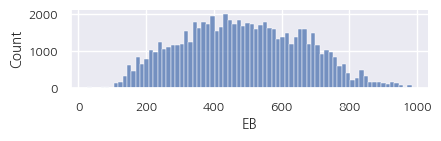

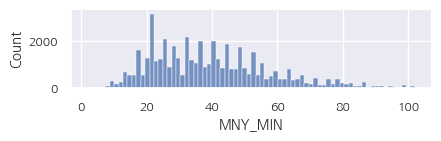

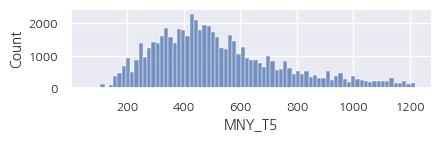

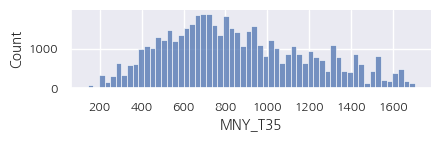

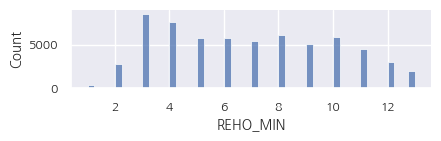

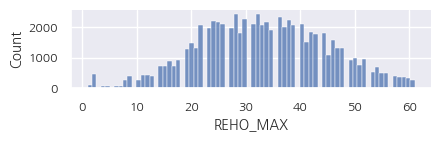

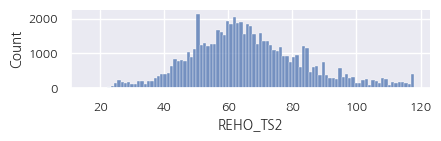

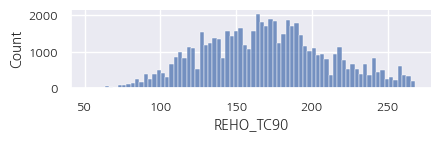

In [17]:
trg_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
for yCol in trg_cols:
    sns.displot(fin_lab_df[yCol], height=1.5, aspect=3)